# LLM - Detect AI Generated Text
## Import

In [56]:
import math
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.corpus import stopwords

from gensim.corpora import Dictionary
from gensim.models import word2vec
from gensim.models import doc2vec

from sklearn.model_selection import StratifiedKFold
from sklearn.utils import resample
from sklearn.metrics import roc_curve ,precision_recall_curve,auc,confusion_matrix,ConfusionMatrixDisplay

from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)
from transformers import PreTrainedTokenizerFast

import keras


[nltk_data] Downloading package punkt to /home/mrtc101/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mrtc101/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [57]:
initial_dataset = pd.read_csv("../data/train_essays.csv")
prompts_dataset = pd.read_csv("../data/train_prompts.csv")
custom_data = pd.read_csv("../data/custom_essays.csv")
downloaded_data_1 = pd.read_csv("../data/train_v3_drcat_01.csv")
#download_data_2 = pd.read_csv("../data/train_v3_drcat_02.csv")

## Data analisis

In [58]:
initial_dataset

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0
...,...,...,...,...
1373,fe6ff9a5,1,There has been a fuss about the Elector Colleg...,0
1374,ff669174,0,Limiting car usage has many advantages. Such a...,0
1375,ffa247e0,0,There's a new trend that has been developing f...,0
1376,ffc237e9,0,As we all know cars are a big part of our soci...,0


In [59]:
initial_dataset.dtypes

id           object
prompt_id     int64
text         object
generated     int64
dtype: object

In [60]:
initial_dataset.shape

(1378, 4)

In [61]:
initial_dataset.describe()

,prompt_id,generated
count,1378.000000,1378.000000
mean,0.486212,0.002177
std,0.499991,0.046625
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,0.000000
max,1.000000,1.000000


`generated` - Whether the essay was written by a student (0) or generated by an LLM (1). This field is the target and is not present in test_essays.csv.

In [62]:
initial_dataset.value_counts("generated")

generated
0    1375
1       3
Name: count, dtype: int64

In [63]:
generated = initial_dataset.value_counts("generated")
generated

generated
0    1375
1       3
Name: count, dtype: int64

In [64]:
generated = generated.apply(lambda x : x/initial_dataset.shape[0])
generated

generated
0    0.997823
1    0.002177
Name: count, dtype: float64

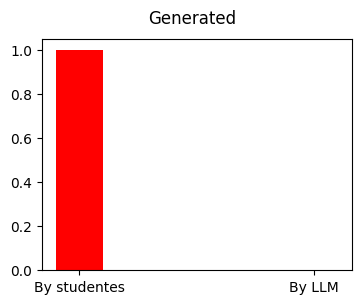

In [65]:
fig, ax = plt.subplots(figsize=(4,3))
fig.suptitle("Generated")
ax.bar(
    x=["By studentes","By LLM"],
    height=generated,
    width=0.2,
    color=["red","green"],
    align="center")
plt.show()

In [66]:
prompts_dataset

,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


In [67]:
prompts = initial_dataset.value_counts("prompt_id")
prompts

prompt_id
0    708
1    670
Name: count, dtype: int64

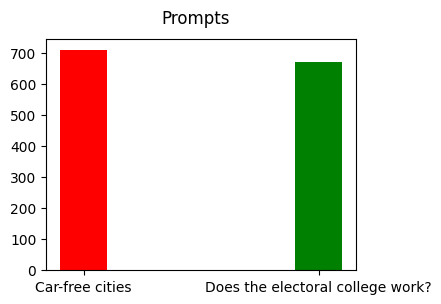

In [68]:
fig, ax = plt.subplots(figsize=(4,3))
fig.suptitle("Prompts")
ax.bar(
    x=["Car-free cities","Does the electoral college work?"],
    height=prompts,
    width=0.2,
    color=["red","green"],
    align="center")
plt.show()

## Handle imbalanced Data

> Because the class distribution is not balanced, most machine learning algorithms will perform
poorly and require modification to avoid simply predicting the majority class in all cases.
Additionally, metrics like classification accuracy lose their meaning and alternate methods for
evaluating predictions on imbalanced examples are required, like ROC area under curve. This is
the foundational challenge of imbalanced classification.
>
> - Jason Brownlee, *Imbalanced Classification with Python* (2020)

> If we think about feature space spatially, we might like all examples in one class to be located on one part
of the space, and those from the other class to appear in another part of the space. [...]
>This is rarely the case, and it is more likely that each class has multiple **concepts** resulting in multiple different groups or clusters of examples in feature space.
>
> - Jason Brownlee, *Imbalanced Classification with Python* (2020)


### Metrics for Imbalanced Data

>Although widely used, classification accuracy is almost universally inappropriate for imbalanced classification. The reason is, a high accuracy (or low error) is achievable by a no skill model that only predicts the majority class. [...]
>
> - Jason Brownlee, *Imbalanced Classification with Python* (2020)

>There are two groups of metrics that may be useful for imbalanced classification because they focus on one class; they are sensitivity-specificity and precision-recall.
>
> - Jason Brownlee, *Imbalanced Classification with Python* (2020)

>One limitation of these metrics is that they assume that the class distribution observed in the training dataset will match the distribution in the test set and in real data when the model is used to make predictions. [...] Ranking metrics don’t make any assumptions about class distributions.
>
> - Jason Brownlee, *Imbalanced Classification with Python* (2020)

>The most commonly used ranking metric is the ROC Curve or ROC Analysis. ROC is an
acronym that means Receiver Operating Characteristic and summarizes a field of study for
analyzing binary classifiers based on their ability to discriminate classes.
>
> - Jason Brownlee, *Imbalanced Classification with Python* (2020)

>Although generally effective, the ROC Curve and ROC AUC can be optimistic under a severe class imbalance, especially when the number of examples in the minority class is small.
An alternative to the ROC Curve is the precision-recall curve that can be used in a similar way, although focuses on the performance of the classifier on the minority class.
>
> - Jason Brownlee, *Imbalanced Classification with Python* (2020)


#### ROC AUC curve

In [69]:
def ROCcurves(model,x_val,y_val):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    
    y_pred = model.predict(x_val).ravel()
    fpr, tpr , _ = roc_curve(y_val,  y_pred)
    auc_ss = auc(fpr,tpr)
    precision, recall, _ = precision_recall_curve(y_val,  y_pred)
    auc_pr = auc(recall, precision)

    # Primer subgráfico
    axs[0].plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='AUC = 0.50')
    axs[0].plot(fpr,tpr, label='ROC curve', color='blue')
    axs[0].set_title(f'ROC curve = {round(auc_ss,3)}')
    axs[0].set_xlabel('FalsePositiveRate')
    axs[0].set_ylabel('TruePositiveRate')
    axs[0].legend()
    # Segundo subgráfico
    axs[1].plot([0, 1], [0,0], color='gray', lw=1, linestyle='--', label='AUC = 0.0')
    axs[1].plot(recall, precision, label='ROC-RP curve', color='orange')
    axs[1].set_title(f'ROC-RP curve = {round(auc_pr,3)}')
    axs[1].set_xlabel('Recall')
    axs[1].set_ylabel('Precision')
    axs[1].legend()
    plt.show()



### Data Sampling for imbalanced data

> Sadly, k-fold cross-validation is not appropriate for evaluating imbalanced classifiers.
[...]
The reason is that the data is split into k-folds with a uniform probability distribution. This might work fine for data with a balanced class distribution, but when the distribution is severely skewed, it is likely that one or more folds will have few or no examples from the minority class.
>
> - Jason Brownlee, *Imbalanced Classification with Python* (2020)

> The solution is to not split the data randomly when using k-fold cross-validation or a train-test
split. [...] For example, we can use a version of k-fold cross-validation that preserves the imbalanced class distribution in each fold. It is called stratified k-fold cross-validation and will enforce the class distribution in each split of the data to match the distribution in the complete training dataset.
>
> - Jason Brownlee, *Imbalanced Classification with Python* (2020)

> Sampling is only performed on the training dataset, the dataset used by an algorithm to
learn a model. It is not performed on the holdout test or validation dataset.
>
> - Jason Brownlee, *Imbalanced Classification with Python* (2020)

- Stratified k-folding CrossValidation
- Random Downsampling
- Adding data as kind of Oversampling

## Adding new Data

Describing the imbalance of this dataset in terms of ration is 1:500. The dataset presents sever imbalance. Previous aproches using only 20 new LLM generated examples manually and random Downsampling technic, didn't reach a higher score than 0.56. 

Concluding that more new data is needed, i downloaded data shared by competitors.

In [70]:
downloaded_data_1["prompt_id"] = downloaded_data_1["prompt_name"].apply(lambda name : 0 if name == "Car-free cities" else 1 if name == "Does the electoral college work?" else 21 )
downloaded_data_1 = downloaded_data_1[["prompt_id","text","label"]].rename(columns={"label":"generated"})

In [71]:
new_data = pd.concat([custom_data,downloaded_data_1],axis=0,ignore_index=True)
new_data["id"] = range(0,new_data.shape[0])

In [72]:
new_data

,id,prompt_id,text,generated
0,0,0,The Advantages of Limiting Car Usage in Suburb...,1
1,1,0,Paris' Driving Ban: A Temporary Solution to En...,1
2,2,0,Bogota's Car-Free Day: A Model for Sustainable...,1
3,3,0,Shifting Trends: The Decline of Car Culture in...,1
4,4,0,The End of Car Culture and the Rise of Sustain...,1
...,...,...,...,...
65525,65525,1,"\n\nDear Senator,\n\nI am writing to you regar...",1
65526,65526,1,\n\nI remember the day distinctively. I was si...,1
65527,65527,1,"\n\nDear Senator, \n\nI am writing this letter...",1
65528,65528,1,"\n\nDear Senator,\n\nI am writing to urge you ...",1


In [73]:
target_data = pd.concat([initial_dataset,new_data],ignore_index=True,axis=0)
target_data

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0
...,...,...,...,...
66903,65525,1,"\n\nDear Senator,\n\nI am writing to you regar...",1
66904,65526,1,\n\nI remember the day distinctively. I was si...,1
66905,65527,1,"\n\nDear Senator, \n\nI am writing this letter...",1
66906,65528,1,"\n\nDear Senator,\n\nI am writing to urge you ...",1


### Data cleaning

In [74]:
print(target_data.shape)
target_data.drop_duplicates(subset=["text"],inplace=True,keep="first")
target_data = target_data.dropna()
target_data.reset_index(inplace=True,drop=True)
print(target_data.shape)

(66908, 4)
(65354, 4)


## Data Feature Engineering

### Training a Tokenizer
Reading the competition discussions lead me to this [Notebook](https://www.kaggle.com/code/datafan07/train-your-own-tokenizer), where is suggested to add words with typos into the vocabulary for better performance by training a tokenizer.

1. normalization
2. pre-tokenization
3. model
4. post-processing

>ByteLevel: 
>
>Splits on whitespaces while remapping all the bytes to a set of visible characters. This technique as been introduced by OpenAI with GPT-2 and has some more or less nice properties:
> - Since it maps on bytes, a tokenizer using this only requires 256 characters as initial alphabet (the number of values a byte can have), as opposed to the 130,000+ Unicode characters.
> - A consequence of the previous point is that it is absolutely unnecessary to have an unknown token using this since we can represent anything with 256 tokens (Youhou!! 🎉🎉)
> - For non ascii characters, it gets completely unreadable, but it works nonetheless!

In [75]:
# Creating Byte-Pair Encoding tokenizer
raw_tokenizer = Tokenizer(models.BPE(unk_token="[UNK]"))
#Cleaning
raw_tokenizer.normalizer =  normalizers.Sequence(
    [
        normalizers.NFC(),
        normalizers.Lowercase(),
        normalizers.Replace("\n"," "),
        normalizers.Replace("\r"," "),
        normalizers.Replace("\t"," ")
    ]    
    )
#First tokenization
raw_tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel()
#Training
special_tokens = ["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]
trainer = trainers.BpeTrainer(show_progress=True,special_tokens=special_tokens)

def data_iter(dataset):
    """
    A generator function for iterating over a dataset in chunks.
    """    
    for i in range(0, len(dataset), 1000):
        yield dataset[i : i + 1000]["text"]

raw_tokenizer.train_from_iterator(data_iter(target_data),trainer)

In [76]:
tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=raw_tokenizer,
    unk_token="[UNK]",
    pad_token="[PAD]",
    cls_token="[CLS]",
    sep_token="[SEP]",
    mask_token="[MASK]",
)

In [77]:
tokenizer.save_pretrained("../data/weight/preTrainedTokenizer")

('../data/weight/preTrainedTokenizer/tokenizer_config.json',
 '../data/weight/preTrainedTokenizer/special_tokens_map.json',
 '../data/weight/preTrainedTokenizer/tokenizer.json')

In [78]:
raw_tokenizer.normalizer.normalize_str("Martín's bag")

"martín's bag"

In [79]:
tokenizer.tokenize("Martín's bag")

['Ġmart', 'Ã', 'Ń', 'n', "'s", 'Ġbag']

##### Words Tokenizing

In [80]:
tokenized_dataset = target_data.copy()
tokenized_dataset["text"] = target_data["text"].apply(lambda x : tokenizer.tokenize(x))
tokenized_dataset

KeyboardInterrupt: 

### Deleting stopwords

In [ ]:
tokenized_stopwords=[token for word in stopwords.words('english') for token in tokenizer.tokenize(word)]

In [ ]:
new_docs = []
for doc in tokenized_dataset["text"]:
    tokens = [word for word in doc if word not in tokenized_stopwords]  # Eliminar stopwords
    new_docs.append(tokens)
tokenized_dataset["text"]=new_docs

#### Text to document embeddings

Need to add all the test documents to the training phase of embedding.

In [ ]:
docs_dataset = tokenized_dataset.copy()
docs_dataset["text"] = [doc2vec.TaggedDocument(row[2],[row[0]]) for row in tokenized_dataset.values]
docs_dataset["text"]

In [ ]:
doc_model = doc2vec.Doc2Vec(documents=docs_dataset["text"],vector_size=100,epochs=50)

In [ ]:
doc_model.dv[0]

In [ ]:
doc_model.save("../data/weight/EmbeddingModel.bin")

In [ ]:
arr = [doc_model.dv[docs_dataset["text"][i].tags] for i in docs_dataset.index]
embeddings_dataset = pd.DataFrame(np.reshape(arr,(len(arr), 100)))
embeddings_dataset

In [ ]:
embeddings_dataset.describe()

#### Normalizar embedding

In [ ]:
embeddings_dataset["norm"]=np.linalg.norm(embeddings_dataset, axis=1)
embeddings_dataset["norm"]

In [ ]:
norm_embeddings_dataset = pd.DataFrame(np.apply_along_axis(lambda x: x / np.linalg.norm(x), axis=1, arr=embeddings_dataset))
norm_embeddings_dataset["normalized_norm"] = (embeddings_dataset['norm'] - embeddings_dataset['norm'].min()) / (embeddings_dataset['norm'].max() - embeddings_dataset['norm'].min())
norm_embeddings_dataset.describe()

In [ ]:
norm_embeddings_dataset

In [ ]:
norm_embeddings_dataset = norm_embeddings_dataset.drop([100],axis=1)

In [ ]:
docs_dataset.shape[0]==norm_embeddings_dataset.shape[0]

In [ ]:
norm_embeddings_dataset.columns

In [ ]:
pre_processed_data = pd.concat([docs_dataset,norm_embeddings_dataset],axis=1)
pre_processed_data

### Inferred Features

In [ ]:
def features(dataset):
    token_count=dataset["text"].apply(lambda x: len(x))
    sentence_count = []
    punctuation_count = []
    apostrofees_count = []
    unk_count = []
    for doc in dataset["text"]:
        unk = 0
        dot = 0
        punctuation = 0
        apostrofees = 0
        for token in doc.words:
            if(token.endswith(".")):
                dot+=1
                punctuation+=1
            elif(token.endswith(",") or token.endswith("?") or token.endswith("!")):
                punctuation+=1
            elif(token.count("'")>0):
                    apostrofees+=token.count("'")
            elif(token=="[UNK]"):
                unk+=1
        sentence_count.append(dot)
        punctuation_count.append(punctuation)
        apostrofees_count.append(apostrofees)
        unk_count.append(unk)
    df = pd.DataFrame(
        columns=["token_num","sent_num","punct_sym","apostrof_sym","unk_num"]
    )
    df["token_num"]=token_count
    df["sent_num"]=sentence_count
    df["punct_sym"]=punctuation_count
    df["apostrof_sym"]=apostrofees_count
    df["unk_num"]=unk_count
    return df

In [ ]:
train_features = features(pre_processed_data)
train_features

In [ ]:
for col in train_features.columns:
    if(train_features[col].max()>0):
        train_features[col] = train_features[col]/np.linalg.norm(train_features[col])
train_features

In [ ]:
pre_processed_data=pd.concat([pre_processed_data,train_features],axis=1).drop("text",axis=1)

In [ ]:
pre_processed_data.describe()

In [ ]:
pre_processed_data.to_csv("../data/pre_process_train.csv",index=False)
#pre_processed_data.loc[:, ~pre_processed_data.columns.str.contains('^Unnamed')].to_csv("../data/pre_process_train.csv",index=False)

## Model Training

In [ ]:
pre_processed_data=pd.read_csv("../data/pre_process_train.csv")
pre_processed_data

/tmp/ipykernel_5079/752621387.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  pre_processed_data=pd.read_csv("../data/pre_process_train.csv")


,id,prompt_id,generated,0,1,2,3,4,5,6,...,96,97,98,99,normalized_norm,token_num,sent_num,punct_sym,apostrof_sym,unk_num
0,0059830c,0,0,0.031006,0.005868,0.000175,0.040530,-0.008923,-0.024766,-0.075533,...,-0.023679,0.007964,-0.097951,-0.013403,0.386702,0.003912,0.004492,0.005521,0.000000,0
1,005db917,0,0,-0.009186,-0.049469,-0.024262,-0.027737,0.044426,-0.023337,-0.037656,...,-0.038399,0.020613,0.022102,-0.008245,0.370435,0.003912,0.004866,0.004616,0.004868,0
2,008f63e3,0,0,-0.127259,-0.009322,0.094947,0.043751,0.081350,-0.062914,-0.065543,...,0.000657,-0.040317,-0.002923,-0.069843,0.396177,0.003912,0.008983,0.006969,0.002434,0
3,00940276,0,0,-0.083473,-0.041759,-0.095021,0.010098,0.053566,-0.077048,-0.098504,...,-0.020585,-0.030012,0.073441,-0.113554,0.405722,0.003912,0.006550,0.007240,0.000000,0
4,00c39458,0,0,-0.100145,-0.040200,0.055441,0.077485,-0.011119,-0.083053,-0.108298,...,0.003750,0.039632,0.014942,-0.046859,0.451901,0.003912,0.008983,0.007602,0.002434,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65349,65525,1,1,-0.001667,-0.005254,0.003478,-0.046774,0.119164,0.074849,0.061789,...,0.053973,0.040873,0.061876,-0.005299,0.270148,0.003912,0.003369,0.003258,0.000000,0
65350,65526,1,1,0.012272,-0.009188,-0.117230,0.009980,0.058147,0.089310,0.026512,...,0.089401,0.052531,0.021248,-0.058458,0.351528,0.003912,0.004305,0.003711,0.000000,0
65351,65527,1,1,-0.003841,0.184542,-0.018318,-0.000038,0.003925,0.038930,-0.023688,...,-0.003992,-0.023140,-0.023155,0.065200,0.295845,0.003912,0.003743,0.003530,0.000000,0
65352,65528,1,1,0.089967,0.021360,-0.036671,-0.036774,0.053695,0.083478,0.015443,...,0.026922,0.049378,0.014431,-0.028427,0.311500,0.003912,0.003369,0.003168,0.000000,0


In [ ]:
def downsampling(X_train,y_train,rand_state,ratio):
    # Concatenate X_train and y_train for ease of downsampling
    train_data = pd.concat([X_train, y_train], axis=1)

    # Identify the class with the majority of instances
    majority_class = train_data[y_train.name].value_counts().idxmax()

    # Separate instances of each class
    majority_class_data = train_data[train_data[y_train.name] == majority_class]
    minority_class_data = train_data[train_data[y_train.name] != majority_class]


    currRatio = len(majority_class_data) / len(minority_class_data)
    if(currRatio<=ratio):
        raise ValueError(f"El ratio de entrada debe ser menor al ratio actual.r={currRatio}")


    # Downsample the majority class to match the number of instances in the minority class
    downsampled_majority_class_data = resample(
        majority_class_data,
        replace=False,
        n_samples=math.floor(ratio*len(minority_class_data)),
        random_state=rand_state
    )

    # Combine the downsampled majority class with the minority class
    downsampled_train_data = pd.concat([downsampled_majority_class_data, minority_class_data])

    # Shuffle the data to avoid any order-based patterns
    downsampled_train_data = downsampled_train_data.sample(frac=1, random_state=rand_state)

    # Separate X_train and y_train after downsampling
    X_train_downsampled = downsampled_train_data.drop(columns=[y_train.name])
    y_train_downsampled = downsampled_train_data[y_train.name]

    return X_train_downsampled, y_train_downsampled

### (NN) Dense connected Neural Network

#### Arquitecture

In [ ]:
input = keras.Input(shape=(pre_processed_data.shape[1]-2,))
x = keras.layers.Dense(pre_processed_data.shape[1]-2,activation="relu")(input)
x = keras.layers.Dense(300,activation="relu")(x)
x = keras.layers.Dense(300,activation="relu")(x)
x = keras.layers.Dense(300,activation="relu")(x)
output = keras.layers.Dense(1,activation="sigmoid")(x)

NNmodel = keras.Model(input,output)

NNmodel.compile(optimizer='adam',
               loss=keras.losses.BinaryCrossentropy(),
               metrics=[keras.metrics.AUC()])

#### Training

In [ ]:
rand_state= random.randint(0,1000)
#NN training with 10-fold cross-validation stratified with random under-sampling technic for imbalanced data
X = pre_processed_data.drop(["id","generated"],axis=1)
Y = pre_processed_data["generated"]
folds = StratifiedKFold(10,shuffle=True,random_state=rand_state)
for fold, (train_index, val_index) in enumerate(folds.split(X,Y)):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = Y.iloc[train_index], Y.iloc[val_index]

    X_train_dwns, y_train_dwns = downsampling(X_train,y_train,rand_state,ratio=1.3)

    #print(f"Fold {fold + 1}: Train {len(train_index)} samples, Validation {len(val_index)} samples")
    #print(f"TRAIN:({y_train[y_train==0].size}:{y_train[y_train==1].size})")
    print(f"DOWNSAMPLED:({y_train_dwns[y_train_dwns==0].size}:{y_train_dwns[y_train_dwns==1].size})")
    #print(f"VAL:({y_val[y_val==0].size}:{y_val[y_val==1].size})")

    NNmodel.fit(X_train_dwns,
                y_train_dwns,
                validation_data=(X_val,y_val),
                batch_size=1000,
                epochs=13)

DOWNSAMPLED:(24633:32022)
Epoch 1/13
57/57 [==============================] - 2s 16ms/step - loss: 0.6035 - auc_1: 0.7129 - val_loss: 0.4861 - val_auc_1: 0.8620
Epoch 2/13
57/57 [==============================] - 1s 12ms/step - loss: 0.4486 - auc_1: 0.8672 - val_loss: 0.4457 - val_auc_1: 0.8919
Epoch 3/13
57/57 [==============================] - 1s 12ms/step - loss: 0.4074 - auc_1: 0.8920 - val_loss: 0.4928 - val_auc_1: 0.9067
Epoch 4/13
57/57 [==============================] - 1s 12ms/step - loss: 0.3824 - auc_1: 0.9060 - val_loss: 0.3812 - val_auc_1: 0.9155
Epoch 5/13
57/57 [==============================] - 1s 13ms/step - loss: 0.3658 - auc_1: 0.9145 - val_loss: 0.4243 - val_auc_1: 0.9242
Epoch 6/13
57/57 [==============================] - 1s 12ms/step - loss: 0.3393 - auc_1: 0.9271 - val_loss: 0.3357 - val_auc_1: 0.9312
Epoch 7/13
57/57 [==============================] - 1s 12ms/step - loss: 0.3179 - auc_1: 0.9363 - val_loss: 0.3051 - val_auc_1: 0.9409
Epoch 8/13
57/57 [===========

2043/2043 [==============================] - 3s 1ms/step


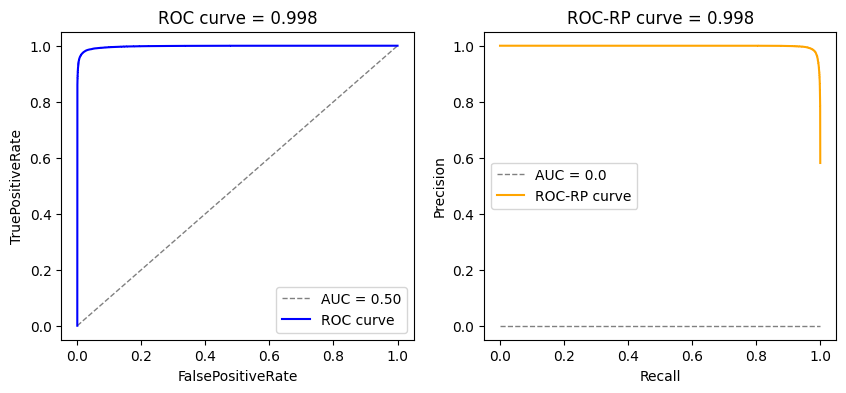

In [ ]:
ROCcurves(NNmodel,X,Y)

2043/2043 [==============================] - 3s 2ms/step


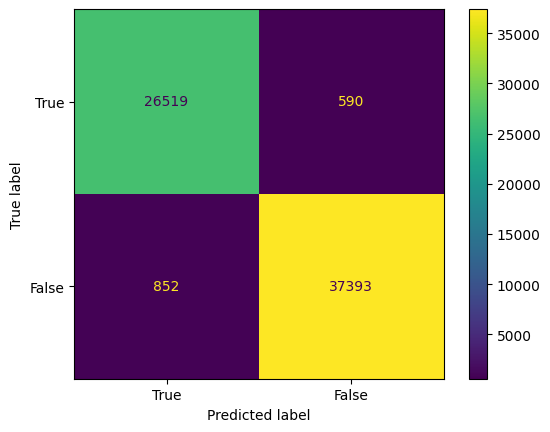

In [ ]:
pred = list(map(lambda pred : 1 if pred > 0.5 else 0,NNmodel.predict(x=X)))
display = ConfusionMatrixDisplay(confusion_matrix(pred,Y),display_labels=["True","False"])
display.plot()

In [ ]:
NNmodel.predict(x=pd.DataFrame(X.iloc[1385]).transpose())

1/1 [==============================] - 0s 13ms/step


array([[1.]], dtype=float32)

In [ ]:
#Save model weights
NNmodel.save("../data/weight/DenseNetwork.h5")

/home/mrtc101/Desktop/ciencias de la computacion/Cursado/4.2Inteligencia Artificial 2/Final/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### CNN (Convolution Neural Network)

#### Arquitecture

In [ ]:
input = keras.Input(shape=(None,pre_processed_data.shape[1]-2),batch_size=500)
x = keras.layers.Reshape(target_shape=(pre_processed_data.shape[1]-2,1))(input)
x = keras.layers.Convolution1D(100,kernel_size=10,padding="same",strides=1,activation="relu")(x)
x = keras.layers.Dense(300,activation="relu")(x)
output = keras.layers.Dense(1,activation="sigmoid")(x)

CNNmodel = keras.Model(input,output)

CNNmodel.compile(optimizer='adam',
               loss=keras.losses.BinaryCrossentropy(),
               metrics=[keras.metrics.AUC()])

#### Training

In [ ]:
rand_state= random.randint(0,1000)
#NN training with 10-fold cross-validation stratified with random under-sampling technic for imbalanced data
X = pre_processed_data.drop(["id","generated"],axis=1)
Y = pre_processed_data["generated"]
folds = StratifiedKFold(10,shuffle=True,random_state=rand_state)
for fold, (train_index, val_index) in enumerate(folds.split(X,Y)):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = Y.iloc[train_index], Y.iloc[val_index]

    X_train_dwns, y_train_dwns = downsampling(X_train,y_train,rand_state,ratio=1.3)

    #print(f"Fold {fold + 1}: Train {len(train_index)} samples, Validation {len(val_index)} samples")
    #print(f"TRAIN:({y_train[y_train==0].size}:{y_train[y_train==1].size})")
    print(f"DOWNSAMPLED:({y_train_dwns[y_train_dwns==0].size}:{y_train_dwns[y_train_dwns==1].size})")
    #print(f"VAL:({y_val[y_val==0].size}:{y_val[y_val==1].size})")

    CNNmodel.fit(X_train_dwns,
                y_train_dwns,
                validation_data=(X_val,y_val),
                batch_size=500,
                epochs=13)

DOWNSAMPLED:(24633:32022)
Epoch 1/13


ValueError: in user code:

    File "/home/mrtc101/Desktop/ciencias de la computacion/Cursado/4.2Inteligencia Artificial 2/Final/venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/home/mrtc101/Desktop/ciencias de la computacion/Cursado/4.2Inteligencia Artificial 2/Final/venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/mrtc101/Desktop/ciencias de la computacion/Cursado/4.2Inteligencia Artificial 2/Final/venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/home/mrtc101/Desktop/ciencias de la computacion/Cursado/4.2Inteligencia Artificial 2/Final/venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1155, in train_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/home/mrtc101/Desktop/ciencias de la computacion/Cursado/4.2Inteligencia Artificial 2/Final/venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1249, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/home/mrtc101/Desktop/ciencias de la computacion/Cursado/4.2Inteligencia Artificial 2/Final/venv/lib/python3.11/site-packages/keras/src/engine/compile_utils.py", line 620, in update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/home/mrtc101/Desktop/ciencias de la computacion/Cursado/4.2Inteligencia Artificial 2/Final/venv/lib/python3.11/site-packages/keras/src/utils/metrics_utils.py", line 77, in decorated
        result = update_state_fn(*args, **kwargs)
    File "/home/mrtc101/Desktop/ciencias de la computacion/Cursado/4.2Inteligencia Artificial 2/Final/venv/lib/python3.11/site-packages/keras/src/metrics/base_metric.py", line 140, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "/home/mrtc101/Desktop/ciencias de la computacion/Cursado/4.2Inteligencia Artificial 2/Final/venv/lib/python3.11/site-packages/keras/src/metrics/confusion_metrics.py", line 1486, in update_state  **
        return metrics_utils.update_confusion_matrix_variables(
    File "/home/mrtc101/Desktop/ciencias de la computacion/Cursado/4.2Inteligencia Artificial 2/Final/venv/lib/python3.11/site-packages/keras/src/utils/metrics_utils.py", line 672, in update_confusion_matrix_variables
        y_pred.shape.assert_is_compatible_with(y_true.shape)

    ValueError: Shapes (None, 107) and (None, 1) are incompatible


2043/2043 [==============================] - 3s 1ms/step


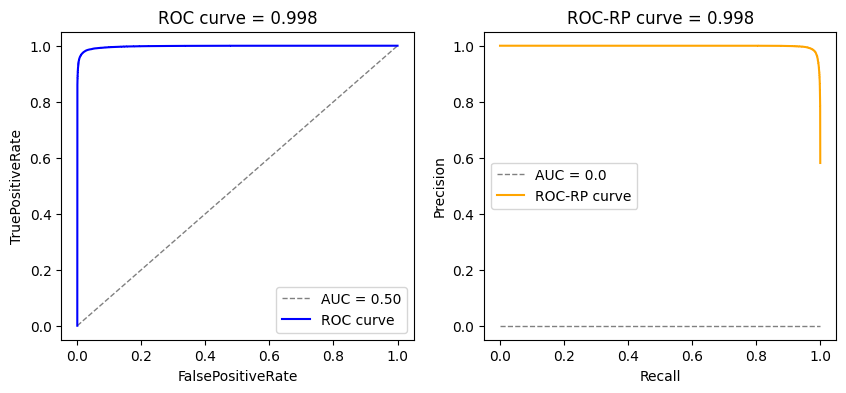

In [ ]:
ROCcurves(NNmodel,X,Y)

2043/2043 [==============================] - 3s 2ms/step


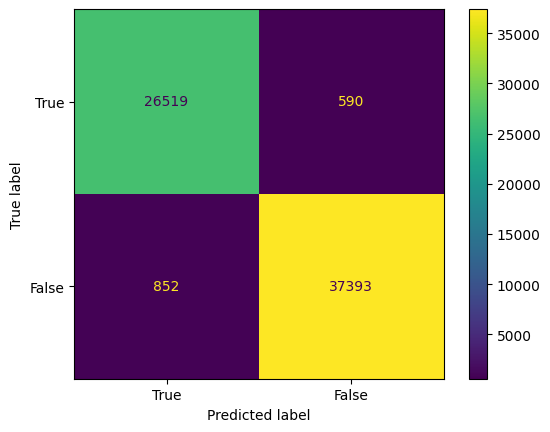

In [ ]:
pred = list(map(lambda pred : 1 if pred > 0.5 else 0,NNmodel.predict(x=X)))
display = ConfusionMatrixDisplay(confusion_matrix(pred,Y),display_labels=["True","False"])
display.plot()

In [ ]:
NNmodel.predict(x=pd.DataFrame(X.iloc[1385]).transpose())

1/1 [==============================] - 0s 13ms/step


array([[1.]], dtype=float32)

In [ ]:
#Save model weights
NNmodel.save("../data/weight/DenseNetwork.h5")

/home/mrtc101/Desktop/ciencias de la computacion/Cursado/4.2Inteligencia Artificial 2/Final/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### RNN (Recurrent Neural Network)

### BERT (Bidirectional Encoder Representation for Transformer)

In [81]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split

# Cargar el tokenizador y el modelo preentrenado BERT para clasificación
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer

BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [82]:
tokenized_dataset = target_data.copy()
tokenized_dataset["text"] = target_data["text"].apply(lambda x : tokenizer(x, truncation=True, padding=True, max_length=128, return_tensors='tf'))

,id,prompt_id,text,generated
0,0059830c,0,"[input_ids, token_type_ids, attention_mask]",0
1,005db917,0,"[input_ids, token_type_ids, attention_mask]",0
2,008f63e3,0,"[input_ids, token_type_ids, attention_mask]",0
3,00940276,0,"[input_ids, token_type_ids, attention_mask]",0
4,00c39458,0,"[input_ids, token_type_ids, attention_mask]",0
...,...,...,...,...
65349,65525,1,"[input_ids, token_type_ids, attention_mask]",1
65350,65526,1,"[input_ids, token_type_ids, attention_mask]",1
65351,65527,1,"[input_ids, token_type_ids, attention_mask]",1
65352,65528,1,"[input_ids, token_type_ids, attention_mask]",1


In [86]:
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [87]:
model.compile(optimizer='adam',
               loss=keras.losses.BinaryCrossentropy(),
               metrics=[keras.metrics.AUC()])

In [88]:
rand_state= random.randint(0,1000)
#NN training with 10-fold cross-validation stratified with random under-sampling technic for imbalanced data
X = pre_processed_data.drop(["id","generated"],axis=1)
Y = pre_processed_data["generated"]
folds = StratifiedKFold(10,shuffle=True,random_state=rand_state)
for fold, (train_index, val_index) in enumerate(folds.split(X,Y)):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = Y.iloc[train_index], Y.iloc[val_index]

    X_train_dwns, y_train_dwns = downsampling(X_train,y_train,rand_state,ratio=1.3)

    #print(f"Fold {fold + 1}: Train {len(train_index)} samples, Validation {len(val_index)} samples")
    #print(f"TRAIN:({y_train[y_train==0].size}:{y_train[y_train==1].size})")
    print(f"DOWNSAMPLED:({y_train_dwns[y_train_dwns==0].size}:{y_train_dwns[y_train_dwns==1].size})")
    #print(f"VAL:({y_val[y_val==0].size}:{y_val[y_val==1].size})")

    model.fit(X_train_dwns,
                y_train_dwns,
                validation_data=(X_val,y_val),
                batch_size=500,
                epochs=13)

DOWNSAMPLED:(24633:32022)
Epoch 1/13


TypeError: in user code:

    File "/home/mrtc101/Desktop/ciencias de la computacion/Cursado/4.2Inteligencia Artificial 2/Final/venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/home/mrtc101/Desktop/ciencias de la computacion/Cursado/4.2Inteligencia Artificial 2/Final/venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/mrtc101/Desktop/ciencias de la computacion/Cursado/4.2Inteligencia Artificial 2/Final/venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/home/mrtc101/Desktop/ciencias de la computacion/Cursado/4.2Inteligencia Artificial 2/Final/venv/lib/python3.11/site-packages/transformers/modeling_tf_utils.py", line 1641, in train_step
        y_pred = self(x, training=True)
    File "/home/mrtc101/Desktop/ciencias de la computacion/Cursado/4.2Inteligencia Artificial 2/Final/venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/tmp/__autograph_generated_filemgso6jrk.py", line 40, in tf__run_call_with_unpacked_inputs
        raise
    File "/tmp/__autograph_generated_fileyy1c36q3.py", line 17, in tf__call
        outputs = ag__.converted_call(ag__.ld(self).bert, (), dict(input_ids=ag__.ld(input_ids), attention_mask=ag__.ld(attention_mask), token_type_ids=ag__.ld(token_type_ids), position_ids=ag__.ld(position_ids), head_mask=ag__.ld(head_mask), inputs_embeds=ag__.ld(inputs_embeds), output_attentions=ag__.ld(output_attentions), output_hidden_states=ag__.ld(output_hidden_states), return_dict=ag__.ld(return_dict), training=ag__.ld(training)), fscope)
    File "/tmp/__autograph_generated_filemgso6jrk.py", line 40, in tf__run_call_with_unpacked_inputs
        raise
    File "/tmp/__autograph_generated_file5linmmrc.py", line 127, in tf__call
        embedding_output = ag__.converted_call(ag__.ld(self).embeddings, (), dict(input_ids=ag__.ld(input_ids), position_ids=ag__.ld(position_ids), token_type_ids=ag__.ld(token_type_ids), inputs_embeds=ag__.ld(inputs_embeds), past_key_values_length=ag__.ld(past_key_values_length), training=ag__.ld(training)), fscope)
    File "/tmp/__autograph_generated_file0e2fijvo.py", line 46, in tf__call
        ag__.if_stmt(ag__.ld(input_ids) is not None, if_body_1, else_body_1, get_state_1, set_state_1, ('inputs_embeds',), 1)
    File "/tmp/__autograph_generated_file0e2fijvo.py", line 41, in if_body_1
        inputs_embeds = ag__.converted_call(ag__.ld(tf).gather, (), dict(params=ag__.ld(self).weight, indices=ag__.ld(input_ids)), fscope)

    TypeError: Exception encountered when calling layer 'tf_bert_for_sequence_classification_1' (type TFBertForSequenceClassification).
    
    in user code:
    
        File "/home/mrtc101/Desktop/ciencias de la computacion/Cursado/4.2Inteligencia Artificial 2/Final/venv/lib/python3.11/site-packages/transformers/modeling_tf_utils.py", line 1557, in run_call_with_unpacked_inputs  *
            return func(self, **unpacked_inputs)
        File "/home/mrtc101/Desktop/ciencias de la computacion/Cursado/4.2Inteligencia Artificial 2/Final/venv/lib/python3.11/site-packages/transformers/models/bert/modeling_tf_bert.py", line 1569, in call  *
            outputs = self.bert(
        File "/home/mrtc101/Desktop/ciencias de la computacion/Cursado/4.2Inteligencia Artificial 2/Final/venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "/tmp/__autograph_generated_filemgso6jrk.py", line 40, in tf__run_call_with_unpacked_inputs
            raise
        File "/tmp/__autograph_generated_file5linmmrc.py", line 127, in tf__call
            embedding_output = ag__.converted_call(ag__.ld(self).embeddings, (), dict(input_ids=ag__.ld(input_ids), position_ids=ag__.ld(position_ids), token_type_ids=ag__.ld(token_type_ids), inputs_embeds=ag__.ld(inputs_embeds), past_key_values_length=ag__.ld(past_key_values_length), training=ag__.ld(training)), fscope)
        File "/tmp/__autograph_generated_file0e2fijvo.py", line 46, in tf__call
            ag__.if_stmt(ag__.ld(input_ids) is not None, if_body_1, else_body_1, get_state_1, set_state_1, ('inputs_embeds',), 1)
        File "/tmp/__autograph_generated_file0e2fijvo.py", line 41, in if_body_1
            inputs_embeds = ag__.converted_call(ag__.ld(tf).gather, (), dict(params=ag__.ld(self).weight, indices=ag__.ld(input_ids)), fscope)
    
        TypeError: Exception encountered when calling layer 'bert' (type TFBertMainLayer).
        
        in user code:
        
            File "/home/mrtc101/Desktop/ciencias de la computacion/Cursado/4.2Inteligencia Artificial 2/Final/venv/lib/python3.11/site-packages/transformers/modeling_tf_utils.py", line 1557, in run_call_with_unpacked_inputs  *
                return func(self, **unpacked_inputs)
            File "/home/mrtc101/Desktop/ciencias de la computacion/Cursado/4.2Inteligencia Artificial 2/Final/venv/lib/python3.11/site-packages/transformers/models/bert/modeling_tf_bert.py", line 780, in call  *
                embedding_output = self.embeddings(
            File "/home/mrtc101/Desktop/ciencias de la computacion/Cursado/4.2Inteligencia Artificial 2/Final/venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler  **
                raise e.with_traceback(filtered_tb) from None
            File "/tmp/__autograph_generated_file0e2fijvo.py", line 46, in tf__call
                ag__.if_stmt(ag__.ld(input_ids) is not None, if_body_1, else_body_1, get_state_1, set_state_1, ('inputs_embeds',), 1)
            File "/tmp/__autograph_generated_file0e2fijvo.py", line 41, in if_body_1
                inputs_embeds = ag__.converted_call(ag__.ld(tf).gather, (), dict(params=ag__.ld(self).weight, indices=ag__.ld(input_ids)), fscope)
        
            TypeError: Exception encountered when calling layer 'embeddings' (type TFBertEmbeddings).
            
            in user code:
            
                File "/home/mrtc101/Desktop/ciencias de la computacion/Cursado/4.2Inteligencia Artificial 2/Final/venv/lib/python3.11/site-packages/transformers/models/bert/modeling_tf_bert.py", line 203, in call  *
                    inputs_embeds = tf.gather(params=self.weight, indices=input_ids)
            
                TypeError: Value passed to parameter 'indices' has DataType float32 not in list of allowed values: int32, int64
            
            
            Call arguments received by layer 'embeddings' (type TFBertEmbeddings):
              • input_ids=tf.Tensor(shape=(None, 107), dtype=float32)
              • position_ids=None
              • token_type_ids=tf.Tensor(shape=(None, 107), dtype=int32)
              • inputs_embeds=None
              • past_key_values_length=0
              • training=True
        
        
        Call arguments received by layer 'bert' (type TFBertMainLayer):
          • input_ids=tf.Tensor(shape=(None, 107), dtype=float32)
          • attention_mask=None
          • token_type_ids=None
          • position_ids=None
          • head_mask=None
          • inputs_embeds=None
          • encoder_hidden_states=None
          • encoder_attention_mask=None
          • past_key_values=None
          • use_cache=None
          • output_attentions=False
          • output_hidden_states=False
          • return_dict=True
          • training=True
    
    
    Call arguments received by layer 'tf_bert_for_sequence_classification_1' (type TFBertForSequenceClassification):
      • input_ids=tf.Tensor(shape=(None, 107), dtype=float32)
      • attention_mask=None
      • token_type_ids=None
      • position_ids=None
      • head_mask=None
      • inputs_embeds=None
      • output_attentions=None
      • output_hidden_states=None
      • return_dict=None
      • labels=None
      • training=True


## Embeddings ploting

In [ ]:
plt.scatter(x=pre_processed_data[pre_processed_data["generated"]==0][20],
            y=pre_processed_data[pre_processed_data["generated"]==0][40])
plt.scatter(x=pre_processed_data[pre_processed_data["generated"]==1][20],
            y=pre_processed_data[pre_processed_data["generated"]==1][40])


KeyError: 20

## Hyperparameter tuning

In [ ]:
def get_model(d,w):
    input = keras.Input(shape=(pre_processed_data.shape[1]-2,))
    x = keras.layers.Dense(pre_processed_data.shape[1]-2,activation="relu")(input)
    for l in range(0,d):
        x = keras.layers.Dense(w,activation="relu")(x)
    output = keras.layers.Dense(1,activation="sigmoid")(x)

    NNmodel = keras.Model(input,output)

    NNmodel.compile(optimizer='adam',
                loss=keras.losses.BinaryCrossentropy(),
                metrics=[keras.metrics.AUC()])
    return NNmodel

In [ ]:
import time
def train_model(model,it):
    rand_state= random.randint(0,1000)
    #NN training with 10-fold cross-validation stratified with random under-sampling technic for imbalanced data
    X = pre_processed_data.drop(["id","generated"],axis=1)
    Y = pre_processed_data["generated"]
    folds = StratifiedKFold(10,shuffle=True,random_state=rand_state)
    for fold, (train_index, val_index) in enumerate(folds.split(X,Y)):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = Y.iloc[train_index], Y.iloc[val_index]

        X_train_dwns, y_train_dwns = downsampling(X_train,y_train,rand_state,ratio=1.3)

        #print(f"Fold {fold + 1}: Train {len(train_index)} samples, Validation {len(val_index)} samples")
        #print(f"TRAIN:({y_train[y_train==0].size}:{y_train[y_train==1].size})")
        print(f"DOWNSAMPLED:({y_train_dwns[y_train_dwns==0].size}:{y_train_dwns[y_train_dwns==1].size})")
        #print(f"VAL:({y_val[y_val==0].size}:{y_val[y_val==1].size})")
        start = time.time()
        NNmodel.fit(X_train_dwns,
                    y_train_dwns,
                    validation_data=(X_val,y_val),
                    batch_size=1000,
                    epochs=it)
        end = time.time()
        return (end - start)

In [ ]:
scores = pd.DataFrame(columns=["iter*10","AUC","AUC-PR","Size","Width","Depth","Time"])
# metrica 0 -> 1
# Ancho de la red 0 -> inf
Width = range(1,1001,200)
# Profundidad de la red 0 -> inf
Depth = range(1,11,2)
# Cantidad de neuronas 0 -> inf f(Width,Depth) acotado a 1.000*10=10.000
# tiempo de ejecución 0 -> inf g(It,f(Width,Depth))
# iteraciones 0 -> inf va de 10 en 10
Iterations = range(1,6)

for d in Depth:
    for w in Width:
        for it in Iterations:
            model = get_model(d-1,w-1)
            t = train_model(model,it)
            
            y_pred = model.predict(X).ravel()
            fpr, tpr , _ = roc_curve(Y,  y_pred)
            auc_ss = auc(fpr,tpr)
            precision, recall, _ = precision_recall_curve(Y,  y_pred)
            auc_pr = auc(recall, precision)

            scores.loc[len(scores)] = [it*10,auc_ss,auc_pr,(w-1)*(d-1),w-1,d-1,t]


In [ ]:
scores[round(scores["AUC"],1)==0.6]

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
scores.sort_values(by=['iter*10',"Size","AUC","Width","Depth"],inplace=True)
for it in scores["iter*10"]:
    ax.scatter3D(scores["Size"],[it]*len(scores),scores["AUC"])